In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install pydot graphviz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 3.4 MB/s eta 0:00:00


In [ ]:
pip install pydot

In [ ]:
pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 74.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 105.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 102.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 100.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 4.7 MB/s eta 0:00:00


In [ ]:
pip install visualkeras


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 997.4/997.4 kB 14.8 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Activation, Add, multiply
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import time


In [ ]:
def load_preprocess_image(img_path):
    img = load_img(img_path, color_mode='grayscale', target_size=(256, 256))
    img = img_to_array(img) / 255.0  # Normalize to [0, 1]
    return img

def load_preprocess_mask(mask_path):
    mask = load_img(mask_path, color_mode='grayscale', target_size=(256, 256))
    mask = img_to_array(mask) / 255.0  # Normalize to [0, 1]
    return mask

def load_dataset(image_dir, mask_dir):
    X = []
    y = []
    for img_name in os.listdir(image_dir):
        if img_name.endswith('.jpg'):
            img_path = os.path.join(image_dir, img_name)
            # Assuming the mask file name convention is imagename_m.png
            mask_name = img_name.split('.')[0] + '_m.jpg'
            mask_path = os.path.join(mask_dir, mask_name)

            if os.path.exists(mask_path):  # Ensure mask file exists
                img = load_preprocess_image(img_path)
                mask = load_preprocess_mask(mask_path)
                X.append(img)
                y.append(mask)
            else:
                print(f"Mask file not found for image: {img_name}")
    X = np.array(X)
    y = np.array(y)
    return X, y


In [ ]:
# Dice Score Function
def dice_score(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Activation, Add
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Residual block with 1x1 convolution to match dimensions
def residual_block(x, filters):
    res = Conv2D(filters, kernel_size=3, strides=1, padding='same')(x)
    res = Activation('relu')(res)
    res = Conv2D(filters, kernel_size=3, strides=1, padding='same')(res)

    # 1x1 convolution to match the dimensions of res
    x = Conv2D(filters, kernel_size=1, strides=1, padding='same')(x)

    res = Add()([res, x])
    res = Activation('relu')(res)
    return res

# U-Net model with Residual blocks but without Attention
def unet_residual(input_size=(256, 256, 1)):
    inputs = Input(input_size)
    conv1 = residual_block(inputs, 64)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = residual_block(pool1, 128)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = residual_block(pool2, 256)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = residual_block(pool3, 512)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = residual_block(pool4, 1024)

    up6 = Conv2D(512, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv5))
    merge6 = concatenate([conv4, up6], axis=3)
    conv6 = residual_block(merge6, 512)

    up7 = Conv2D(256, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv6))
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = residual_block(merge7, 256)

    up8 = Conv2D(128, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv7))
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = residual_block(merge8, 128)

    up9 = Conv2D(64, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv8))
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = residual_block(merge9, 64)

    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs, conv10)
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model



In [ ]:
# Directory paths for dataset
image_dir = '/content/drive/MyDrive/Su-Dataset/Brain Tumor Segmentation Dataset 1/image'
mask_dir = '/content/drive/MyDrive/Su-Dataset/Brain Tumor Segmentation Dataset 1/mask'

# Load dataset
X, y = load_dataset(image_dir, mask_dir)




In [ ]:
# Split dataset into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [ ]:
# Define model
model = unet_residual(input_size=(256, 256, 1))

# Callbacks (optional)
checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_loss', mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=25, mode='min', verbose=1)


In [ ]:
# Measure training time
start_time = time.time()

In [15]:
# Fit model
history = model.fit(
    X_train, y_train,
    epochs=52,
    batch_size=16,
    validation_data=(X_val, y_val),
    callbacks=[checkpoint, early_stopping]
)


Epoch 1/52
44/44 ━━━━━━━━━━━━━━━━━━━━ 424s 9s/step - accuracy: 0.8869 - loss: 0.3750 - val_accuracy: 0.9749 - val_loss: 0.0729
Epoch 2/52
44/44 ━━━━━━━━━━━━━━━━━━━━ 414s 9s/step - accuracy: 0.9754 - loss: 0.0719 - val_accuracy: 0.9749 - val_loss: 0.0602
Epoch 3/52
44/44 ━━━━━━━━━━━━━━━━━━━━ 415s 9s/step - accuracy: 0.9744 - loss: 0.0633 - val_accuracy: 0.9749 - val_loss: 0.0515
Epoch 4/52
44/44 ━━━━━━━━━━━━━━━━━━━━ 414s 9s/step - accuracy: 0.9732 - loss: 0.0549 - val_accuracy: 0.9761 - val_loss: 0.0490
Epoch 5/52
44/44 ━━━━━━━━━━━━━━━━━━━━ 416s 9s/step - accuracy: 0.9811 - loss: 0.0430 - val_accuracy: 0.9842 - val_loss: 0.0373
Epoch 6/52
44/44 ━━━━━━━━━━━━━━━━━━━━ 412s 9s/step - accuracy: 0.9835 - loss: 0.0387 - val_accuracy: 0.9864 - val_loss: 0.0295
Epoch 7/52
44/44 ━━━━━━━━━━━━━━━━━━━━ 414s 9s/step - accuracy: 0.9883 - loss: 0.0260 - val_accuracy: 0.9854 - val_loss: 0.0328
Epoch 8/52
44/44 ━━━━━━━━━━━━━━━━━━━━ 416s 9s/step - accuracy: 0.9873 - loss: 0.0288 - val_accuracy: 0.9874 - v

In [16]:
end_time = time.time()
total_training_time = end_time - start_time
print(f"Total Training Time: {total_training_time} seconds")

Total Training Time: 19474.85373544693 seconds


5/5 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step


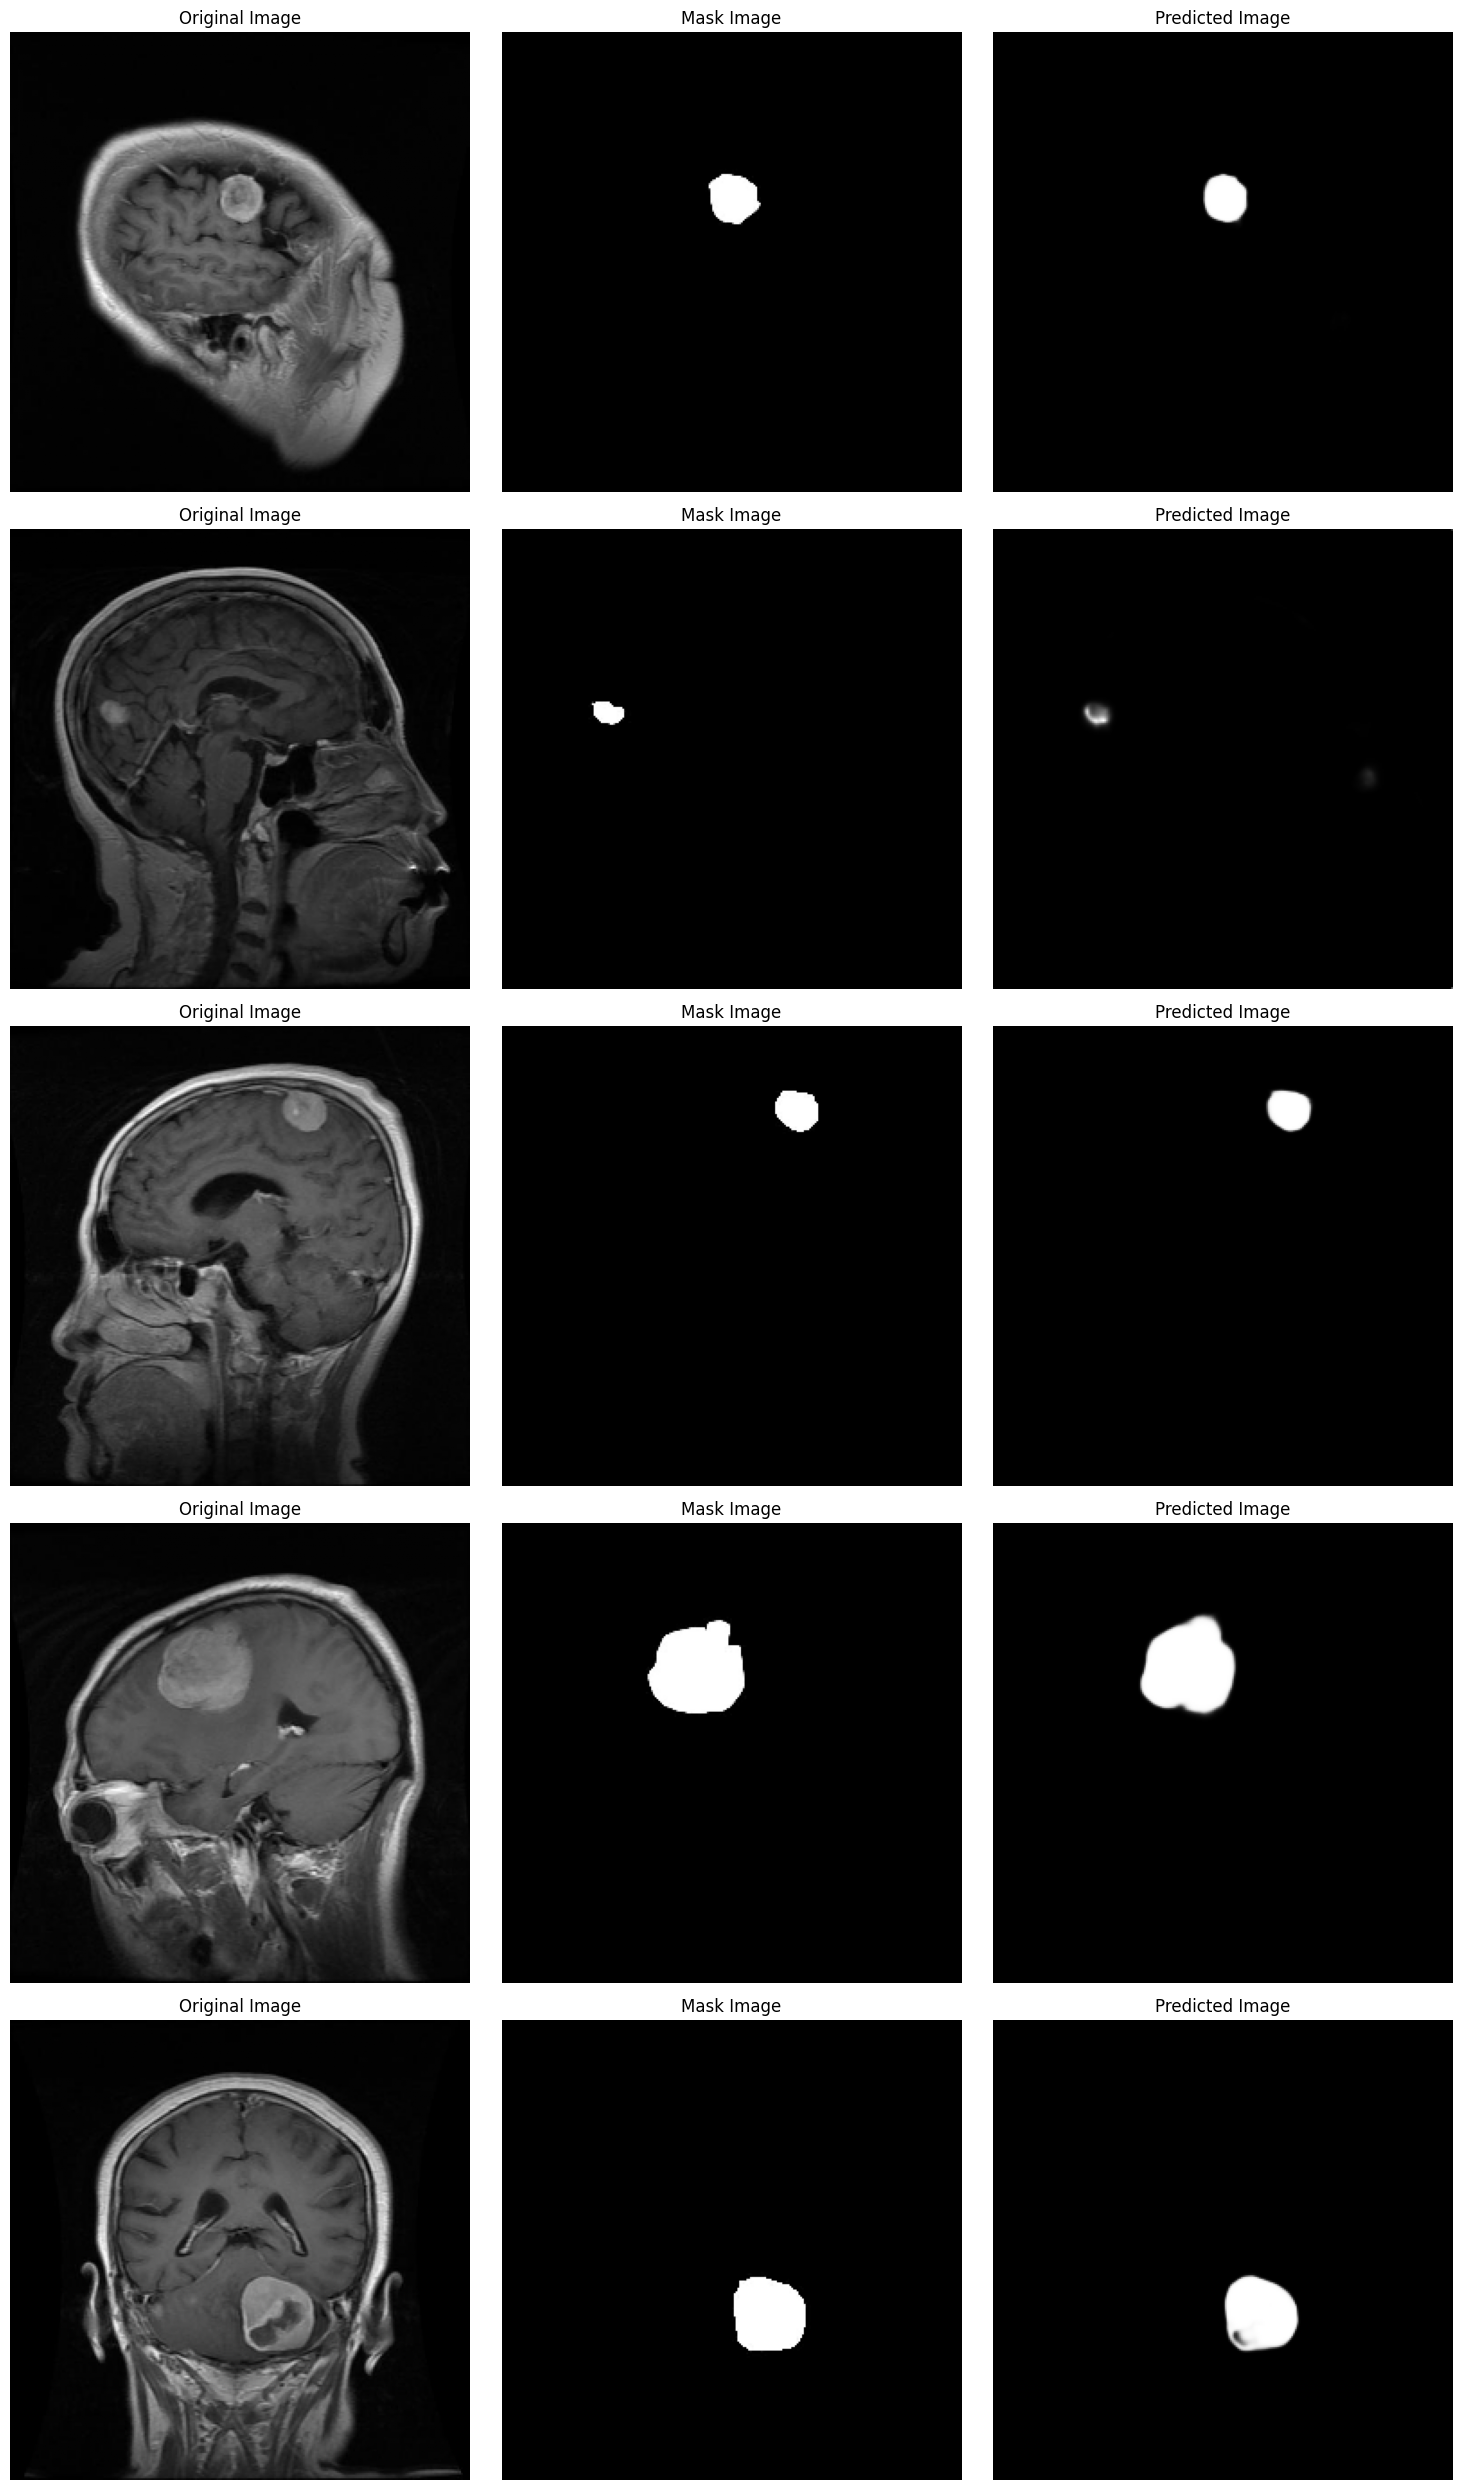

In [17]:
# Display original, mask, and predicted images
def display_images(X, y, model, num_images=5):
    predictions = model.predict(X)
    plt.figure(figsize=(15, 5 * num_images))
    for i in range(num_images):
        plt.subplot(num_images, 3, 3 * i + 1)
        plt.imshow(X[i].reshape(256, 256), cmap='gray')
        plt.title('Original Image')
        plt.axis('off')

        plt.subplot(num_images, 3, 3 * i + 2)
        plt.imshow(y[i].reshape(256, 256), cmap='gray')
        plt.title('Mask Image')
        plt.axis('off')

        plt.subplot(num_images, 3, 3 * i + 3)
        plt.imshow(predictions[i].reshape(256, 256), cmap='gray')
        plt.title('Predicted Image')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Display images
display_images(X_test, y_test, model, num_images=5)

In [ ]:
# Plot training & validation accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [ ]:
# Manually calculate dice score for test set
y_pred = model.predict(X_test)
test_dice_scores = [dice_score(y_true, y_pred) for y_true, y_pred in zip(y_test, y_pred)]
mean_test_dice_score = np.mean(test_dice_scores)
print(f"Test Dice Score: {mean_test_dice_score}")

In [ ]:
# Extracting the training history
history_dict = history.history

# Finding the epoch with the maximum training accuracy
max_train_acc_epoch = history_dict['accuracy'].index(max(history_dict['accuracy'])) + 1
max_train_acc = max(history_dict['accuracy'])

# Finding the epoch with the maximum validation accuracy
max_val_acc_epoch = history_dict['val_accuracy'].index(max(history_dict['val_accuracy'])) + 1
max_val_acc = max(history_dict['val_accuracy'])

# Finding the epoch with the minimum training loss
min_train_loss_epoch = history_dict['loss'].index(min(history_dict['loss'])) + 1
min_train_loss = min(history_dict['loss'])

# Finding the epoch with the minimum validation loss
min_val_loss_epoch = history_dict['val_loss'].index(min(history_dict['val_loss'])) + 1
min_val_loss = min(history_dict['val_loss'])

# Printing the results
print(f"Maximum Training Accuracy: {max_train_acc:.4f} at epoch {max_train_acc_epoch}")
print(f"Maximum Validation Accuracy: {max_val_acc:.4f} at epoch {max_val_acc_epoch}")
print(f"Minimum Training Loss: {min_train_loss:.4f} at epoch {min_train_loss_epoch}")
print(f"Minimum Validation Loss: {min_val_loss:.4f} at epoch {min_val_loss_epoch}")


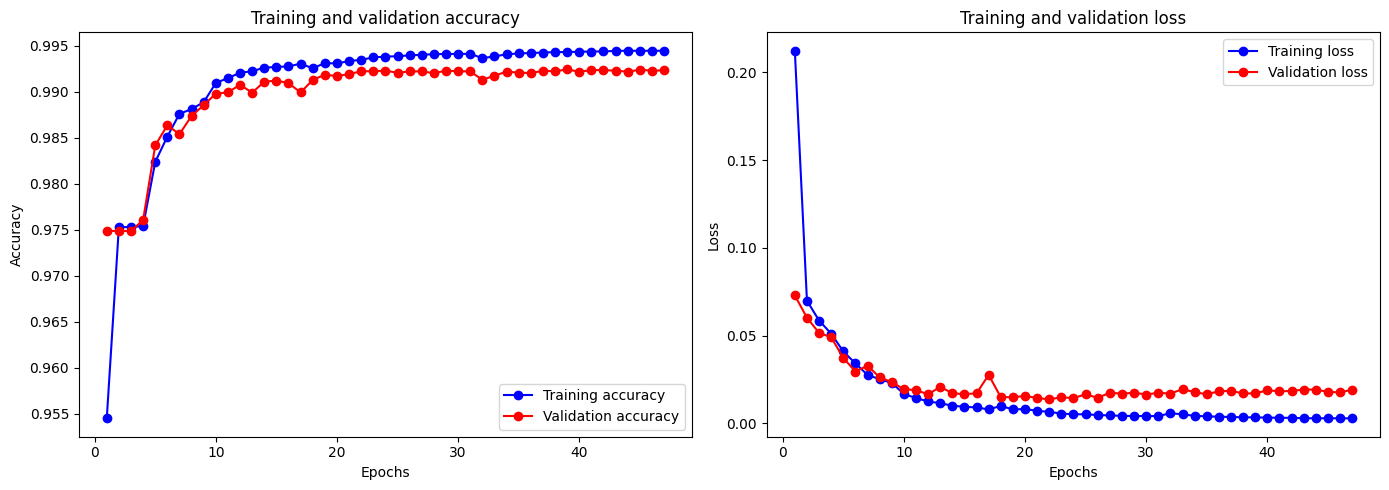

In [21]:
import matplotlib.pyplot as plt

# Extracting the training history
history_dict = history.history

# Values for plotting
epochs = range(1, len(history_dict['accuracy']) + 1)
train_accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']

# Plotting training and validation accuracy
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracy, 'bo-', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'ro-', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Extracting the training history
history_dict = history.history

# Values for plotting
epochs = range(1, len(history_dict['accuracy']) + 1)
train_accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']

# Finding the epoch with the maximum training accuracy
max_train_acc_epoch = history_dict['accuracy'].index(max(history_dict['accuracy'])) + 1
max_train_acc = max(history_dict['accuracy'])

# Finding the epoch with the maximum validation accuracy
max_val_acc_epoch = history_dict['val_accuracy'].index(max(history_dict['val_accuracy'])) + 1
max_val_acc = max(history_dict['val_accuracy'])

# Finding the epoch with the minimum training loss
min_train_loss_epoch = history_dict['loss'].index(min(history_dict['loss'])) + 1
min_train_loss = min(history_dict['loss'])

# Finding the epoch with the minimum validation loss
min_val_loss_epoch = history_dict['val_loss'].index(min(history_dict['val_loss'])) + 1
min_val_loss = min(history_dict['val_loss'])

# Plotting training and validation accuracy
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracy, 'bo-', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'ro-', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Annotating the maximum accuracy points
plt.annotate(f'Max Train Acc\nEpoch: {max_train_acc_epoch}\nAcc: {max_train_acc:.4f}',
             xy=(max_train_acc_epoch, max_train_acc),
             xytext=(max_train_acc_epoch, max_train_acc + 0.1),
             arrowprops=dict(facecolor='black', shrink=0.05),
             horizontalalignment='right')

plt.annotate(f'Max Val Acc\nEpoch: {max_val_acc_epoch}\nAcc: {max_val_acc:.4f}',
             xy=(max_val_acc_epoch, max_val_acc),
             xytext=(max_val_acc_epoch, max_val_acc + 0.1),
             arrowprops=dict(facecolor='black', shrink=0.05),
             horizontalalignment='right')

# Plotting training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Annotating the minimum loss points
plt.annotate(f'Min Train Loss\nEpoch: {min_train_loss_epoch}\nLoss: {min_train_loss:.4f}',
             xy=(min_train_loss_epoch, min_train_loss),
             xytext=(min_train_loss_epoch, min_train_loss + 0.1),
             arrowprops=dict(facecolor='black', shrink=0.05),
             horizontalalignment='right')

plt.annotate(f'Min Val Loss\nEpoch: {min_val_loss_epoch}\nLoss: {min_val_loss:.4f}',
             xy=(min_val_loss_epoch, min_val_loss),
             xytext=(min_val_loss_epoch, min_val_loss + 0.1),
             arrowprops=dict(facecolor='black', shrink=0.05),
             horizontalalignment='right')

plt.tight_layout()
plt.show()


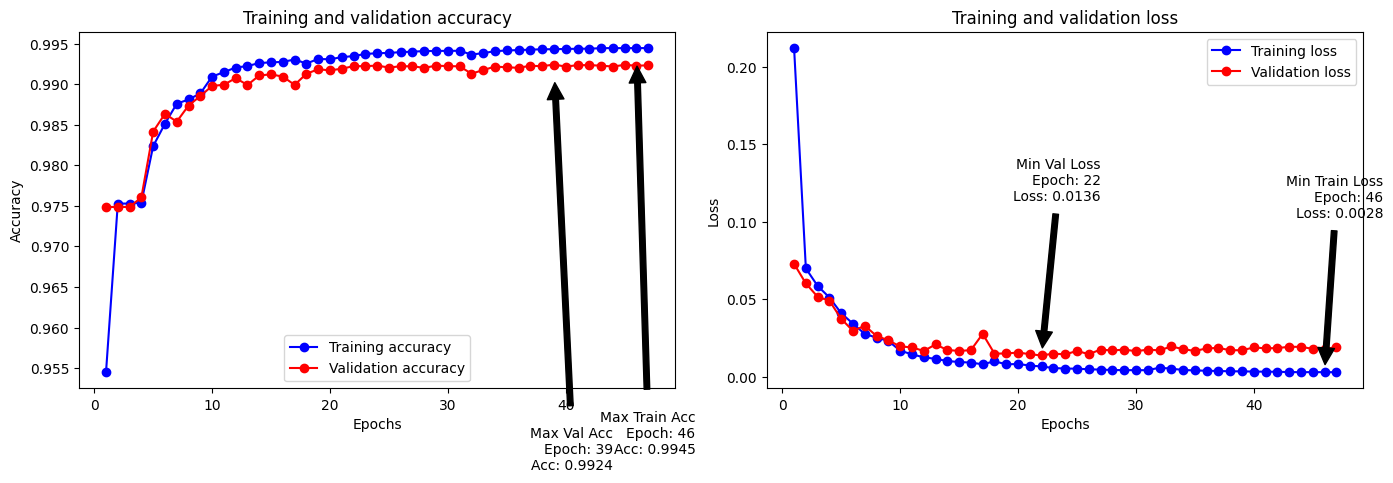

In [23]:
import matplotlib.pyplot as plt

# Extracting the training history
history_dict = history.history

# Values for plotting
epochs = range(1, len(history_dict['accuracy']) + 1)
train_accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']

# Finding the epoch with the maximum training accuracy
max_train_acc_epoch = history_dict['accuracy'].index(max(history_dict['accuracy'])) + 1
max_train_acc = max(history_dict['accuracy'])

# Finding the epoch with the maximum validation accuracy
max_val_acc_epoch = history_dict['val_accuracy'].index(max(history_dict['val_accuracy'])) + 1
max_val_acc = max(history_dict['val_accuracy'])

# Finding the epoch with the minimum training loss
min_train_loss_epoch = history_dict['loss'].index(min(history_dict['loss'])) + 1
min_train_loss = min(history_dict['loss'])

# Finding the epoch with the minimum validation loss
min_val_loss_epoch = history_dict['val_loss'].index(min(history_dict['val_loss'])) + 1
min_val_loss = min(history_dict['val_loss'])

# Plotting training and validation accuracy
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracy, 'bo-', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'ro-', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Annotating the maximum accuracy points
plt.annotate(f'Max Train Acc\nEpoch: {max_train_acc_epoch}\nAcc: {max_train_acc:.4f}',
             xy=(max_train_acc_epoch, max_train_acc),
             xytext=(max_train_acc_epoch + 5, max_train_acc - 0.05),
             arrowprops=dict(facecolor='black', shrink=0.05),
             horizontalalignment='right')

plt.annotate(f'Max Val Acc\nEpoch: {max_val_acc_epoch}\nAcc: {max_val_acc:.4f}',
             xy=(max_val_acc_epoch, max_val_acc),
             xytext=(max_val_acc_epoch + 5, max_val_acc - 0.05),
             arrowprops=dict(facecolor='black', shrink=0.05),
             horizontalalignment='right')

# Plotting training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Annotating the minimum loss points
plt.annotate(f'Min Train Loss\nEpoch: {min_train_loss_epoch}\nLoss: {min_train_loss:.4f}',
             xy=(min_train_loss_epoch, min_train_loss),
             xytext=(min_train_loss_epoch + 5, min_train_loss + 0.1),
             arrowprops=dict(facecolor='black', shrink=0.05),
             horizontalalignment='right')

plt.annotate(f'Min Val Loss\nEpoch: {min_val_loss_epoch}\nLoss: {min_val_loss:.4f}',
             xy=(min_val_loss_epoch, min_val_loss),
             xytext=(min_val_loss_epoch + 5, min_val_loss + 0.1),
             arrowprops=dict(facecolor='black', shrink=0.05),
             horizontalalignment='right')

plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Extracting the training history
history_dict = history.history

# Values for plotting
epochs = range(1, len(history_dict['accuracy']) + 1)
train_accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']

# Finding the epoch with the maximum training accuracy
max_train_acc_epoch = history_dict['accuracy'].index(max(history_dict['accuracy'])) + 1
max_train_acc = max(history_dict['accuracy'])

# Finding the epoch with the maximum validation accuracy
max_val_acc_epoch = history_dict['val_accuracy'].index(max(history_dict['val_accuracy'])) + 1
max_val_acc = max(history_dict['val_accuracy'])

# Finding the epoch with the minimum training loss
min_train_loss_epoch = history_dict['loss'].index(min(history_dict['loss'])) + 1
min_train_loss = min(history_dict['loss'])

# Finding the epoch with the minimum validation loss
min_val_loss_epoch = history_dict['val_loss'].index(min(history_dict['val_loss'])) + 1
min_val_loss = min(history_dict['val_loss'])

# Plotting training and validation accuracy
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracy, 'bo-', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'ro-', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Annotating the maximum accuracy points without arrows
plt.annotate(f'Max Train Acc\nEpoch: {max_train_acc_epoch}\nAcc: {max_train_acc:.4f}',
             xy=(max_train_acc_epoch, max_train_acc),
             xytext=(max_train_acc_epoch, max_train_acc + 0.1),
             horizontalalignment='right')

plt.annotate(f'Max Val Acc\nEpoch: {max_val_acc_epoch}\nAcc: {max_val_acc:.4f}',
             xy=(max_val_acc_epoch, max_val_acc),
             xytext=(max_val_acc_epoch, max_val_acc + 0.1),
             horizontalalignment='right')

# Plotting training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Annotating the minimum loss points without arrows
plt.annotate(f'Min Train Loss\nEpoch: {min_train_loss_epoch}\nLoss: {min_train_loss:.4f}',
             xy=(min_train_loss_epoch, min_train_loss),
             xytext=(min_train_loss_epoch, min_train_loss + 0.1),
             horizontalalignment='right')

plt.annotate(f'Min Val Loss\nEpoch: {min_val_loss_epoch}\nLoss: {min_val_loss:.4f}',
             xy=(min_val_loss_epoch, min_val_loss),
             xytext=(min_val_loss_epoch, min_val_loss + 0.1),
             horizontalalignment='right')

plt.tight_layout()
plt.show()


In [25]:
# Assuming your trained model is stored in the variable `model`
# and your test data is stored in `X_test` and `y_test`

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

# Print the test accuracy and loss
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")


Test Accuracy: 0.9910
Test Loss: 0.0327


In [ ]:
from sklearn.metrics import classification_report

# Assuming your trained model is stored in the variable `model`
# and your test data is stored in `X_test` and `y_test`

# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Flatten the arrays
y_test_flat = y_test.flatten().astype(int)
y_pred_flat = y_pred.flatten().astype(int)

# Calculate precision, recall, and F1-score
print(classification_report(y_test_flat, y_pred_flat))


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay


5/5 ━━━━━━━━━━━━━━━━━━━━ 15s 3s/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   9626227
           1       0.87      0.87      0.87    204173

    accuracy                           0.99   9830400
   macro avg       0.93      0.94      0.93   9830400
weighted avg       0.99      0.99      0.99   9830400



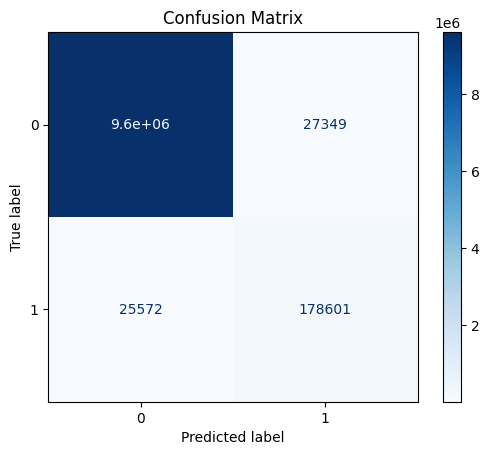

<ipython-input-28-f62dab3cabf1>:89: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


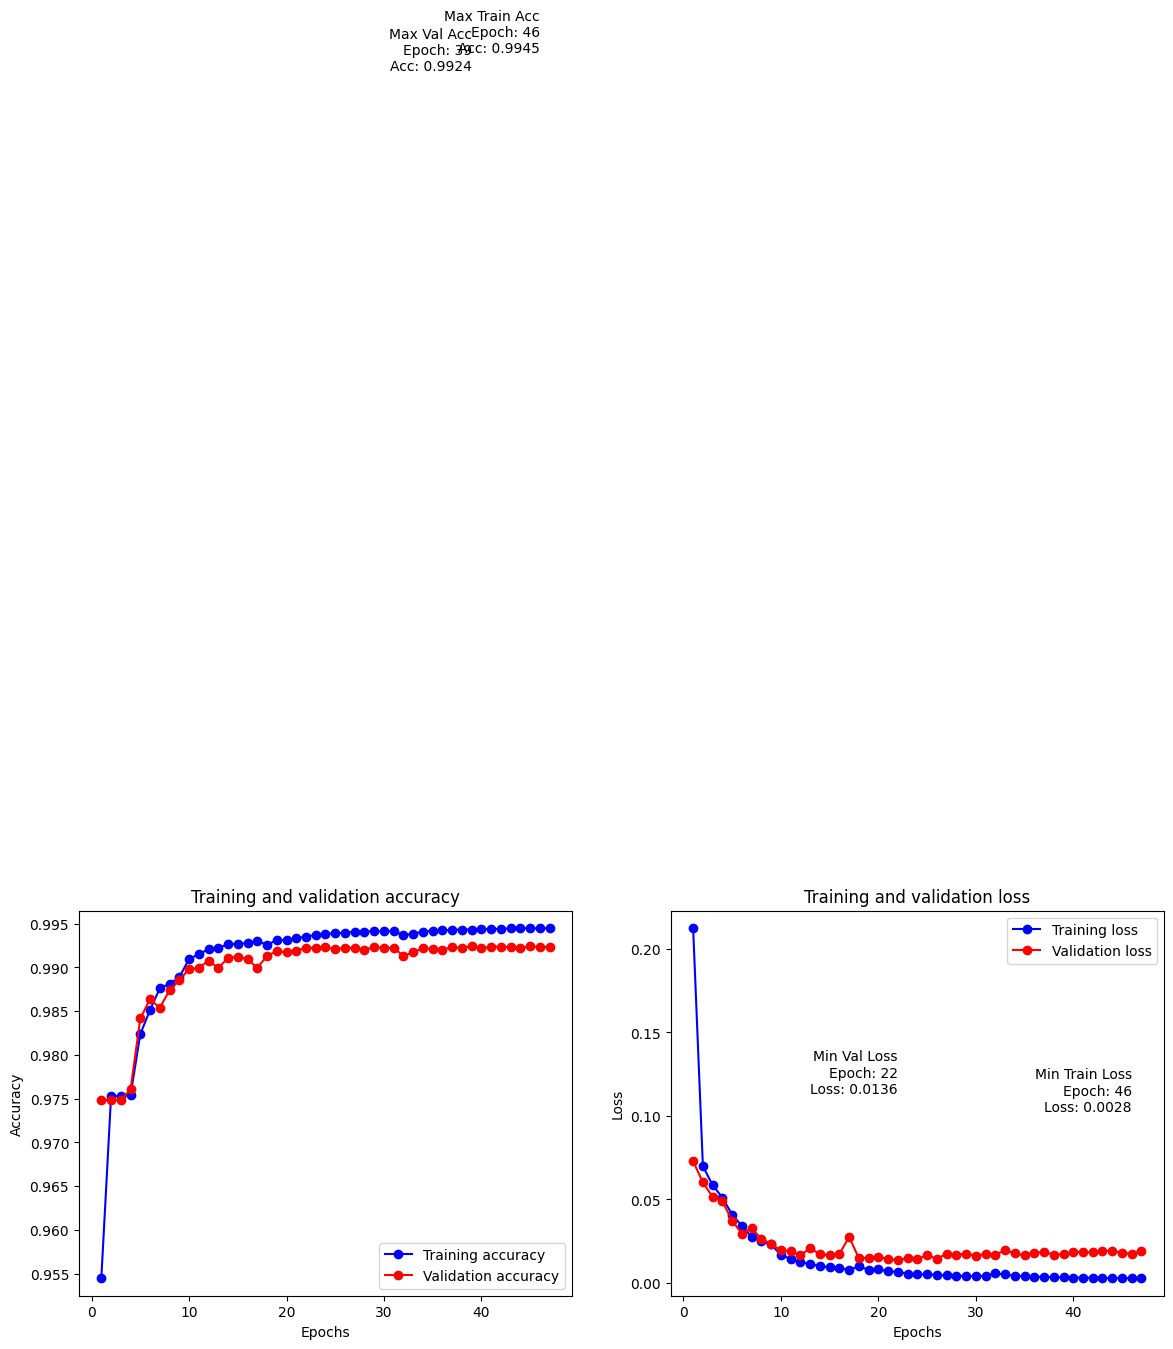

In [28]:
# Make predictions on the test set
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Flatten the arrays
y_test_flat = y_test.flatten().astype(int)
y_pred_flat = y_pred.flatten().astype(int)

# Calculate precision, recall, and F1-score
print(classification_report(y_test_flat, y_pred_flat))

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test_flat, y_pred_flat)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Extracting the training history
history_dict = history.history

# Values for plotting
epochs = range(1, len(history_dict['accuracy']) + 1)
train_accuracy = history_dict['accuracy']
val_accuracy = history_dict['val_accuracy']
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']

# Finding the epoch with the maximum training accuracy
max_train_acc_epoch = history_dict['accuracy'].index(max(history_dict['accuracy'])) + 1
max_train_acc = max(history_dict['accuracy'])

# Finding the epoch with the maximum validation accuracy
max_val_acc_epoch = history_dict['val_accuracy'].index(max(history_dict['val_accuracy'])) + 1
max_val_acc = max(history_dict['val_accuracy'])

# Finding the epoch with the minimum training loss
min_train_loss_epoch = history_dict['loss'].index(min(history_dict['loss'])) + 1
min_train_loss = min(history_dict['loss'])

# Finding the epoch with the minimum validation loss
min_val_loss_epoch = history_dict['val_loss'].index(min(history_dict['val_loss'])) + 1
min_val_loss = min(history_dict['val_loss'])

# Plotting training and validation accuracy
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_accuracy, 'bo-', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'ro-', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Annotating the maximum accuracy points without arrows
plt.annotate(f'Max Train Acc\nEpoch: {max_train_acc_epoch}\nAcc: {max_train_acc:.4f}',
             xy=(max_train_acc_epoch, max_train_acc),
             xytext=(max_train_acc_epoch, max_train_acc + 0.1),
             horizontalalignment='right')

plt.annotate(f'Max Val Acc\nEpoch: {max_val_acc_epoch}\nAcc: {max_val_acc:.4f}',
             xy=(max_val_acc_epoch, max_val_acc),
             xytext=(max_val_acc_epoch, max_val_acc + 0.1),
             horizontalalignment='right')

# Plotting training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'bo-', label='Training loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Annotating the minimum loss points without arrows
plt.annotate(f'Min Train Loss\nEpoch: {min_train_loss_epoch}\nLoss: {min_train_loss:.4f}',
             xy=(min_train_loss_epoch, min_train_loss),
             xytext=(min_train_loss_epoch, min_train_loss + 0.1),
             horizontalalignment='right')

plt.annotate(f'Min Val Loss\nEpoch: {min_val_loss_epoch}\nLoss: {min_val_loss:.4f}',
             xy=(min_val_loss_epoch, min_val_loss),
             xytext=(min_val_loss_epoch, min_val_loss + 0.1),
             horizontalalignment='right')

plt.tight_layout()
plt.show()


In [ ]:
# Manually calculate dice score for test set
y_pred = model.predict(X_test)
test_dice_scores = [dice_score(y_true, y_pred) for y_true, y_pred in zip(y_test, y_pred)]
mean_test_dice_score = np.mean(test_dice_scores)
print(f"Test Dice Score: {mean_test_dice_score}")

In [30]:
# Extracting the training history
history_dict = history.history

# Finding the epoch with the maximum training accuracy
max_train_acc_epoch = history_dict['accuracy'].index(max(history_dict['accuracy'])) + 1
max_train_acc = max(history_dict['accuracy'])

# Finding the epoch with the maximum validation accuracy
max_val_acc_epoch = history_dict['val_accuracy'].index(max(history_dict['val_accuracy'])) + 1
max_val_acc = max(history_dict['val_accuracy'])

# Finding the epoch with the minimum training loss
min_train_loss_epoch = history_dict['loss'].index(min(history_dict['loss'])) + 1
min_train_loss = min(history_dict['loss'])

# Finding the epoch with the minimum validation loss
min_val_loss_epoch = history_dict['val_loss'].index(min(history_dict['val_loss'])) + 1
min_val_loss = min(history_dict['val_loss'])

# Printing the results
print(f"Maximum Training Accuracy: {max_train_acc:.4f} at epoch {max_train_acc_epoch}")
print(f"Maximum Validation Accuracy: {max_val_acc:.4f} at epoch {max_val_acc_epoch}")
print(f"Minimum Training Loss: {min_train_loss:.4f} at epoch {min_train_loss_epoch}")
print(f"Minimum Validation Loss: {min_val_loss:.4f} at epoch {min_val_loss_epoch}")

Maximum Training Accuracy: 0.9945 at epoch 46
Maximum Validation Accuracy: 0.9924 at epoch 39
Minimum Training Loss: 0.0028 at epoch 46
Minimum Validation Loss: 0.0136 at epoch 22


In [31]:
# Manually calculate dice score for test set
y_pred = model.predict(X_test)
test_dice_scores = [dice_score(y_true, y_pred) for y_true, y_pred in zip(y_test, y_pred)]
mean_test_dice_score = np.mean(test_dice_scores)
print(f"Test Dice Score: {mean_test_dice_score}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 15s 3s/step
Test Dice Score: 0.8542409539222717
